In [ ]:
!pip install torch torchvision segment-anything datasets opencv-python-headless matplotlib tqdm scikit-learn git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6qx1uyhv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6qx1uyhv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
# Import libraries
import os
import shutil
import cv2
import numpy as np
import torch
import clip
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from datasets import load_dataset
from pathlib import Path
from tqdm import tqdm
from scipy.ndimage import label as scipy_label
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import KMeans
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [ ]:
# Load SAM checkpoint
sam_checkpoint_vit_b = "/content/drive/MyDrive/sam_vit_b_01ec64.pth"
sam_checkpoint_vit_h = "/content/drive/MyDrive/sam_vit_h_4b8939.pth"

if os.path.exists(sam_checkpoint_vit_b):
    sam_checkpoint = sam_checkpoint_vit_b
    model_type = "vit_b"
    print("Using SAM vit_b checkpoint.")
elif os.path.exists(sam_checkpoint_vit_h):
    sam_checkpoint = sam_checkpoint_vit_h
    model_type = "vit_h"
    print("Falling back to SAM vit_h checkpoint.")
else:
    raise FileNotFoundError("Neither SAM vit_b nor vit_h checkpoint found. Please download one of the checkpoints manually:\n"
                            "- vit_b: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P /content/drive/MyDrive/\n"
                            "- vit_h: wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /content/drive/MyDrive/")

Using SAM vit_b checkpoint.


In [ ]:
# Define ingredients list (103 classes from FoodSeg103, including background)
ingredients = np.array([
    "background", "candy", "egg tart", "french fries", "chocolate", "biscuit", "popcorn", "pudding",
    "ice cream", "cheese butter", "cake", "wine", "milkshake", "coffee", "juice", "milk", "tea",
    "almond", "red beans", "cashew", "dried cranberries", "soy", "walnut", "peanut", "egg",
    "apple", "date", "apricot", "avocado", "banana", "strawberry", "cherry", "blueberry",
    "raspberry", "mango", "olives", "peach", "lemon", "pear", "fig", "pineapple", "grape",
    "kiwi", "melon", "orange", "watermelon", "steak", "pork", "chicken duck", "sausage",
    "fried meat", "lamb", "sauce", "crab", "fish", "shellfish", "shrimp", "soup", "bread",
    "corn", "hamburg", "pizza", "hanamaki baozi", "wonton dumplings", "pasta", "noodles",
    "rice", "pie", "tofu", "eggplant", "potato", "garlic", "cauliflower", "tomato", "kelp",
    "seaweed", "spring onion", "rape", "ginger", "okra", "lettuce", "pumpkin", "cucumber",
    "white radish", "carrot", "asparagus", "bamboo shoots", "broccoli", "celery stick",
    "cilantro mint", "snow peas", "cabbage", "bean sprouts", "onion", "pepper", "green beans",
    "French beans", "king oyster mushroom", "shiitake", "enoki mushroom", "oyster mushroom",
    "white button mushroom", "salad", "other ingredients"
])

In [ ]:
# --- Confirm Hardware ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


# --- Preprocessing Section ---

In [ ]:
# Load dataset
ds = load_dataset("EduardoPacheco/FoodSeg103")
val_dataset = ds["validation"]

README.md:   0%|          | 0.00/6.71k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/357M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4983 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [ ]:
# Validate dataset labels before preprocessing
def validate_dataset_labels(dataset, split_name):
    invalid_label_counts = {}
    for entry in tqdm(dataset, desc=f"Validating {split_name} dataset labels"):
        mask = np.array(entry["label"])
        unique_labels = np.unique(mask)
        invalid_labels = unique_labels[unique_labels > 102]
        if invalid_labels.size > 0:
            entry_id = entry["id"]
            invalid_label_counts[entry_id] = invalid_labels.tolist()

    if invalid_label_counts:
        print(f"Found invalid labels in {split_name} dataset:")
        for entry_id, labels in invalid_label_counts.items():
            print(f"Entry {entry_id}: Invalid labels {labels}")
        print(f"Total entries with invalid labels: {len(invalid_label_counts)}")
    else:
        print(f"No invalid labels found in {split_name} dataset.")
    return invalid_label_counts

In [ ]:
# Run validation on validation dataset
invalid_label_counts = validate_dataset_labels(val_dataset, "validation")

Validating validation dataset labels: 100%|██████████| 2135/2135 [00:16<00:00, 126.29it/s]

Found invalid labels in validation dataset:
Entry 6: Invalid labels [103]
Entry 9: Invalid labels [103]
Entry 43: Invalid labels [103]
Entry 45: Invalid labels [103]
Entry 47: Invalid labels [103]
Entry 55: Invalid labels [103]
Entry 56: Invalid labels [103]
Entry 57: Invalid labels [103]
Entry 116: Invalid labels [103]
Entry 124: Invalid labels [103]
Entry 130: Invalid labels [103]
Entry 134: Invalid labels [103]
Entry 140: Invalid labels [103]
Entry 175: Invalid labels [103]
Entry 209: Invalid labels [103]
Entry 273: Invalid labels [103]
Entry 283: Invalid labels [103]
Entry 301: Invalid labels [103]
Entry 308: Invalid labels [103]
Entry 315: Invalid labels [103]
Entry 346: Invalid labels [103]
Entry 386: Invalid labels [103]
Entry 450: Invalid labels [103]
Entry 513: Invalid labels [103]
Entry 520: Invalid labels [103]
Entry 528: Invalid labels [103]
Entry 545: Invalid labels [103]
Entry 553: Invalid labels [103]
Entry 601: Invalid labels [103]
Entry 629: Invalid labels [103]
Entry 

In [ ]:
def preprocess_image(image, size=(640, 640)):
    image = np.array(image)
    image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return image

In [ ]:
def preprocess_mask(mask, size=(640, 640), entry_id=None):
    mask = np.array(mask)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask = mask.astype(np.uint8)
    invalid_labels = mask > 102
    if invalid_labels.any():
        print(f"Entry {entry_id}: Found invalid labels in mask: {np.unique(mask[invalid_labels])}. Mapping to background (0).")
        mask[invalid_labels] = 0
    return mask

In [ ]:
def save_preprocessed_data(dataset, split_name, base_dir="/content/drive/MyDrive/sam_data/foodseg103"):
    split_dir = Path(base_dir) / split_name
    images_dir = split_dir / "images"
    masks_dir = split_dir / "masks"
    images_dir.mkdir(parents=True, exist_ok=True)
    masks_dir.mkdir(parents=True, exist_ok=True)

    for i, entry in enumerate(tqdm(dataset, desc=f"Preprocessing {split_name} data")):
        image = preprocess_image(entry["image"])
        mask = preprocess_mask(entry["label"], entry_id=entry["id"])
        img_path = images_dir / f"{entry['id']}.jpg"
        mask_path = masks_dir / f"{entry['id']}.png"
        cv2.imwrite(str(img_path), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(mask_path), mask)

In [ ]:
base_dir = "/content/drive/MyDrive/sam_data/foodseg103"
val_dir = Path(base_dir) / "val"
if val_dir.exists():
    print("Deleting existing validation data to re-preprocess...")
    shutil.rmtree(val_dir)
print("Preprocessing validation data...")
save_preprocessed_data(val_dataset, "val", base_dir=base_dir)

Deleting existing validation data to re-preprocess...
Preprocessing validation data...


Preprocessing val data:   0%|          | 3/2135 [00:00<01:12, 29.60it/s]

Entry 6: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   1%|          | 13/2135 [00:00<00:51, 41.32it/s]

Entry 9: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   2%|▏         | 48/2135 [00:01<00:50, 41.02it/s]

Entry 43: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 45: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 47: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   3%|▎         | 64/2135 [00:01<00:45, 45.56it/s]

Entry 55: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 56: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 57: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   6%|▌         | 124/2135 [00:02<00:45, 43.98it/s]

Entry 116: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 124: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   6%|▋         | 134/2135 [00:03<00:51, 39.06it/s]

Entry 130: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 134: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   7%|▋         | 146/2135 [00:03<00:45, 43.25it/s]

Entry 140: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:   9%|▊         | 182/2135 [00:04<00:46, 42.21it/s]

Entry 175: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  10%|█         | 215/2135 [00:04<00:41, 45.83it/s]

Entry 209: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  13%|█▎        | 281/2135 [00:06<00:48, 38.05it/s]

Entry 273: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  14%|█▎        | 290/2135 [00:06<00:46, 39.61it/s]

Entry 283: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  14%|█▍        | 306/2135 [00:07<01:04, 28.33it/s]

Entry 301: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  15%|█▍        | 314/2135 [00:07<00:59, 30.49it/s]

Entry 308: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  15%|█▌        | 322/2135 [00:08<00:57, 31.68it/s]

Entry 315: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  17%|█▋        | 353/2135 [00:09<00:51, 34.54it/s]

Entry 346: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  18%|█▊        | 392/2135 [00:10<00:57, 30.34it/s]

Entry 386: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  21%|██▏       | 458/2135 [00:11<00:37, 45.03it/s]

Entry 450: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  24%|██▍       | 520/2135 [00:13<00:36, 44.28it/s]

Entry 513: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 520: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  25%|██▌       | 535/2135 [00:13<00:37, 42.21it/s]

Entry 528: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  26%|██▌       | 551/2135 [00:13<00:35, 44.68it/s]

Entry 545: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 553: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  28%|██▊       | 606/2135 [00:15<00:33, 44.98it/s]

Entry 601: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  30%|██▉       | 636/2135 [00:15<00:32, 45.72it/s]

Entry 629: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  38%|███▊      | 812/2135 [00:20<00:56, 23.62it/s]

Entry 808: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 813: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  39%|███▉      | 835/2135 [00:21<00:38, 33.89it/s]

Entry 832: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  40%|███▉      | 848/2135 [00:21<00:36, 35.24it/s]

Entry 844: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  41%|████      | 865/2135 [00:22<00:37, 33.88it/s]

Entry 859: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  42%|████▏     | 889/2135 [00:22<00:34, 35.72it/s]

Entry 883: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  43%|████▎     | 926/2135 [00:23<00:28, 43.12it/s]

Entry 919: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 922: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  44%|████▍     | 936/2135 [00:24<00:27, 44.26it/s]

Entry 933: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  45%|████▌     | 962/2135 [00:24<00:28, 41.83it/s]

Entry 953: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 960: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  46%|████▌     | 972/2135 [00:24<00:27, 42.05it/s]

Entry 964: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  48%|████▊     | 1020/2135 [00:26<00:28, 39.63it/s]

Entry 1015: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  49%|████▉     | 1050/2135 [00:26<00:26, 41.27it/s]

Entry 1042: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1043: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  50%|████▉     | 1065/2135 [00:27<00:27, 38.36it/s]

Entry 1062: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1064: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  52%|█████▏    | 1108/2135 [00:28<00:27, 37.23it/s]

Entry 1102: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1105: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  54%|█████▍    | 1158/2135 [00:29<00:23, 42.45it/s]

Entry 1152: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  56%|█████▌    | 1199/2135 [00:30<00:23, 40.06it/s]

Entry 1191: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  58%|█████▊    | 1235/2135 [00:31<00:20, 43.23it/s]

Entry 1227: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  59%|█████▉    | 1270/2135 [00:32<00:19, 43.62it/s]

Entry 1265: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  60%|██████    | 1285/2135 [00:32<00:22, 38.53it/s]

Entry 1279: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  61%|██████    | 1294/2135 [00:32<00:22, 37.71it/s]

Entry 1291: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  65%|██████▍   | 1382/2135 [00:35<00:29, 25.60it/s]

Entry 1376: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  67%|██████▋   | 1432/2135 [00:37<00:17, 39.06it/s]

Entry 1428: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  69%|██████▉   | 1470/2135 [00:38<00:18, 35.16it/s]

Entry 1463: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  71%|███████▏  | 1526/2135 [00:40<00:13, 45.23it/s]

Entry 1519: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  73%|███████▎  | 1551/2135 [00:40<00:13, 43.24it/s]

Entry 1543: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  75%|███████▍  | 1596/2135 [00:41<00:12, 42.80it/s]

Entry 1588: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  75%|███████▌  | 1606/2135 [00:41<00:12, 42.41it/s]

Entry 1599: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1606: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  76%|███████▌  | 1626/2135 [00:42<00:11, 44.03it/s]

Entry 1620: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  77%|███████▋  | 1643/2135 [00:42<00:10, 46.65it/s]

Entry 1639: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  80%|███████▉  | 1702/2135 [00:44<00:10, 42.29it/s]

Entry 1693: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  81%|████████▏ | 1737/2135 [00:45<00:09, 42.99it/s]

Entry 1728: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  85%|████████▍ | 1811/2135 [00:47<00:09, 33.38it/s]

Entry 1806: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  87%|████████▋ | 1856/2135 [00:48<00:07, 36.26it/s]

Entry 1851: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  88%|████████▊ | 1869/2135 [00:49<00:06, 38.52it/s]

Entry 1861: Found invalid labels in mask: [103]. Mapping to background (0).
Entry 1864: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data:  92%|█████████▏| 1962/2135 [00:51<00:04, 40.05it/s]

Entry 1958: Found invalid labels in mask: [103]. Mapping to background (0).


Preprocessing val data: 100%|██████████| 2135/2135 [00:55<00:00, 38.56it/s]


# --- Inference Section ---

In [ ]:
# Load SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [ ]:
# Load CLIP model (stick with ViT-B/32 for faster inference; can upgrade to ViT-L/336 if needed)
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 51.1MiB/s]


In [ ]:
# Prepare text prompts for CLIP with multiple variations
text_prompt_templates = [
    "a photo of {ingredient}",
    "a plate of {ingredient} on a table",
    "freshly cooked {ingredient}",
    "fresh {ingredient} in a bowl"
]
text_prompts = []
for ingredient in ingredients:
    prompts = [template.format(ingredient=ingredient) for template in text_prompt_templates]
    text_prompts.append(prompts)

In [ ]:
# Tokenize and encode all prompts
text_features = []
for ingredient_prompts in text_prompts:
    text_inputs = clip.tokenize(ingredient_prompts).to(device)
    with torch.no_grad():
        features = clip_model.encode_text(text_inputs)
        features /= features.norm(dim=-1, keepdim=True)
        features = features.mean(dim=0)  # Average across prompts
    text_features.append(features)
text_features = torch.stack(text_features).to(device)

In [ ]:
# Define patch augmentation for CLIP
patch_augmentation = T.Compose([
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor()
])

In [ ]:
def get_color_based_prompts(image_rgb, num_clusters=5):
    # Resize image for faster clustering
    small_image = cv2.resize(image_rgb, (160, 160), interpolation=cv2.INTER_LINEAR)
    pixels = small_image.reshape(-1, 3).astype(np.float32)

    # Apply KMeans clustering to segment by color
    kmeans = KMeans(n_clusters=min(num_clusters, len(pixels)), random_state=0).fit(pixels)
    labels = kmeans.labels_.reshape(small_image.shape[:2])

    # Scale labels back to original image size
    labels = cv2.resize(labels.astype(np.uint8), (image_rgb.shape[1], image_rgb.shape[0]),
                        interpolation=cv2.INTER_NEAREST)

    boxes = []
    points = []
    for cluster in np.unique(labels):
        mask = (labels == cluster).astype(np.uint8)
        if mask.sum() < 500:  # Ignore small regions
            continue

        # Compute bounding box
        y, x = np.where(mask)
        if len(y) == 0:
            continue
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        boxes.append([x_min, y_min, x_max, y_max])

        # Sample points within the region
        num_points = min(3, len(y) // 1000 + 1)  # Adaptive number of points
        indices = np.random.choice(len(y), size=num_points, replace=False)
        region_points = np.array([[x[i], y[i]] for i in indices], dtype=np.float32)
        points.append(region_points)

    boxes = np.array(boxes) if boxes else np.zeros((0, 4), dtype=np.float32)
    points = np.concatenate(points, axis=0) if points else np.zeros((0, 2), dtype=np.float32)
    point_labels = np.ones(len(points), dtype=np.int32)  # All points are foreground
    return boxes, points, point_labels

In [ ]:
def refine_mask(mask):
    if mask.sum() < 100:  # Skip refinement for small masks
        return mask
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    return mask

In [ ]:
def erode_mask_for_patch(mask):
    kernel = np.ones((5, 5), np.uint8)
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
    return eroded_mask

In [ ]:
def estimate_num_clusters(mask):
    # Estimate number of clusters based on mask size
    area = mask.sum()
    if area < 1000:
        return 1
    elif area < 5000:
        return 2
    elif area < 10000:
        return 3
    else:
        return 5

In [ ]:
def split_mask_if_needed(mask, image_rgb):
    y, x = np.where(mask)
    if len(y) < 100:
        return [(mask, image_rgb[y.min():y.max(), x.min():x.max()])]

    region = image_rgb[y.min():y.max(), x.min():x.max()]
    if region.shape[0] == 0 or region.shape[1] == 0:
        return [(mask, region)]

    pixels = region.reshape(-1, 3).astype(np.float32)
    num_clusters = estimate_num_clusters(mask)
    if num_clusters == 1:
        return [(mask, region)]

    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pixels)
    labels = kmeans.labels_.reshape(region.shape[:2])

    sub_masks = []
    for cluster in range(kmeans.n_clusters):
        sub_mask = (labels == cluster).astype(np.uint8)
        full_sub_mask = np.zeros_like(mask, dtype=np.uint8)
        full_sub_mask[y.min():y.max(), x.min():x.max()] = sub_mask
        sub_region = image_rgb[y.min():y.max(), x.min():x.max()] * sub_mask[:, :, np.newaxis]
        sub_masks.append((full_sub_mask, sub_region))
    return sub_masks

In [ ]:
def compute_iou(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

In [ ]:
def merge_overlapping_masks(labeled_masks, iou_threshold=0.5):
    if not labeled_masks:
        return []

    # Sort by score to prioritize higher-confidence masks
    labeled_masks = sorted(labeled_masks, key=lambda x: x[2], reverse=True)
    merged_masks = []
    used = set()

    for i, (label_i, mask_i, score_i) in enumerate(labeled_masks):
        if i in used:
            continue
        current_mask = mask_i
        current_label = label_i
        current_score = score_i
        used.add(i)

        for j, (label_j, mask_j, score_j) in enumerate(labeled_masks[i+1:], start=i+1):
            if j in used:
                continue
            if label_i != label_j:
                continue
            iou = compute_iou(current_mask, mask_j)
            if iou > iou_threshold:
                current_mask = np.logical_or(current_mask, mask_j).astype(np.uint8)
                used.add(j)

        merged_masks.append((current_label, current_mask, current_score))

    return merged_masks

In [ ]:
def segment_and_classify(image_path, output_dir):
    image = cv2.imread(str(image_path))
    if image is None:
        print(f"Error: Could not load {image_path}")
        return None, None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image_rgb)

    # Get prompts using color-based segmentation
    boxes, points, point_labels = get_color_based_prompts(image_rgb)
    if len(boxes) == 0 and len(points) == 0:
        print(f"No food regions detected in {image_path} using color-based segmentation.")
        return None, None, None

    # First pass: Generate initial masks
    all_masks = []
    all_scores = []
    for box_idx, box in enumerate(tqdm(boxes, desc=f"Processing boxes for {image_path.stem} (Pass 1)", leave=False)):
        box = box.reshape(1, 4)
        if box.shape != (1, 4):
            print(f"Invalid box shape for box {box_idx} in {image_path}: {box.shape}. Skipping.")
            continue

        # Use points if available
        if len(points) > 0:
            try:
                masks, scores, _ = predictor.predict(
                    box=box,
                    point_coords=points,
                    point_labels=point_labels,
                    multimask_output=True
                )
                all_masks.append(masks)
                all_scores.append(scores)
            except Exception as e:
                print(f"Error processing box {box_idx} in {image_path}: {e}")
                continue
        else:
            try:
                masks, scores, _ = predictor.predict(
                    box=box,
                    multimask_output=True
                )
                all_masks.append(masks)
                all_scores.append(scores)
            except Exception as e:
                print(f"Error processing box {box_idx} in {image_path}: {e}")
                continue

    # Combine initial masks
    if not all_masks:
        print(f"No valid masks generated for {image_path} in Pass 1")
        return None, None, None

    masks = np.concatenate(all_masks, axis=0)
    scores = np.concatenate(all_scores, axis=0)

    # Second pass: Refine masks by recomputing prompts
    refined_masks = []
    refined_scores = []
    for mask_idx, (mask, score) in enumerate(zip(masks, scores)):
        if mask.sum() < 20 or score < 0.6:
            continue
        mask = refine_mask(mask)

        # Recompute bounding box around the mask
        y, x = np.where(mask)
        if len(y) == 0:
            continue
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        new_box = np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)

        # Sample points within the mask
        num_points = min(3, len(y) // 1000 + 1)
        indices = np.random.choice(len(y), size=num_points, replace=False)
        new_points = np.array([[x[i], y[i]] for i in indices], dtype=np.float32)
        new_point_labels = np.ones(len(new_points), dtype=np.int32)

        try:
            new_masks, new_scores, _ = predictor.predict(
                box=new_box,
                point_coords=new_points,
                point_labels=new_point_labels,
                multimask_output=True
            )
            # Take the best mask
            best_idx = np.argmax(new_scores)
            refined_masks.append(new_masks[best_idx])
            refined_scores.append(new_scores[best_idx])
        except Exception as e:
            print(f"Error refining mask {mask_idx} in {image_path}: {e}")
            refined_masks.append(mask)
            refined_scores.append(score)

    if not refined_masks:
        print(f"No valid masks after refinement for {image_path}")
        return None, None, None

    masks = np.array(refined_masks)
    scores = np.array(refined_scores)

    output_dir.mkdir(parents=True, exist_ok=True)
    labeled_masks = []
    total_masks = len(masks)
    kept_masks = 0
    for i, (mask, score) in enumerate(zip(masks, scores)):
        if mask.sum() < 20 or score < 0.6:
            continue
        kept_masks += 1

        mask = refine_mask(mask)
        sub_mask_pairs = split_mask_if_needed(mask, image_rgb)
        for j, (sub_mask, sub_region) in enumerate(sub_mask_pairs):
            y, x = np.where(sub_mask)
            if len(y) == 0:
                continue
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()

            # Erode the mask for cleaner patch extraction
            eroded_mask = erode_mask_for_patch(sub_mask[y_min:y_max, x_min:x_max])
            patch = image_rgb[y_min:y_max, x_min:x_max] * eroded_mask[:, :, np.newaxis]
            if patch.shape[0] == 0 or patch.shape[1] == 0:
                continue

            # Prepare patch for CLIP with augmentation
            patch_pil = Image.fromarray(patch.astype(np.uint8))
            logits_list = []
            for _ in range(3):  # Apply augmentation 3 times
                patch_tensor = patch_augmentation(patch_pil).unsqueeze(0).to(device)
                with torch.no_grad():
                    image_features = clip_model.encode_image(patch_tensor)
                    image_features /= image_features.norm(dim=-1, keepdim=True)
                    logits = (image_features @ text_features.T).squeeze(0)
                    logits_list.append(logits)

            # Average logits across augmentations
            logits = torch.stack(logits_list).mean(dim=0)

            # Apply confidence threshold (simplified; can be class-specific)
            max_logit = logits.max().item()
            if max_logit < 0.15:  # Adjusted threshold
                pred_label = len(ingredients) - 1  # "other ingredients"
            else:
                pred_label = logits.argmax().item()

            if pred_label == 0:  # Skip background predictions
                continue

            mask_path = output_dir / f"{image_path.stem}_mask_{i}_{j}_{ingredients[pred_label]}.png"
            cv2.imwrite(str(mask_path), sub_mask * 255)
            labeled_masks.append((pred_label, sub_mask, score))

    # Merge overlapping masks
    labeled_masks = merge_overlapping_masks(labeled_masks)

    # Save merged masks
    for idx, (pred_label, sub_mask, score) in enumerate(labeled_masks):
        mask_path = output_dir / f"{image_path.stem}_mask_merged_{idx}_{ingredients[pred_label]}.png"
        cv2.imwrite(str(mask_path), sub_mask * 255)

    print(f"Image {image_path.stem}: Generated {total_masks} masks, kept {kept_masks} after filtering, {len(labeled_masks)} after merging.")
    return masks, scores, labeled_masks

In [ ]:
# Process validation images
input_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/images")
output_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/predictions")
output_dir.mkdir(parents=True, exist_ok=True)

for f in output_dir.glob("*_mask_*.png"):
    f.unlink()

image_paths = list(input_dir.glob("*.jpg"))
image_paths = image_paths[:200]
for img_path in tqdm(image_paths, desc="Segmenting and classifying images"):
    segment_and_classify(img_path, output_dir)

Segmenting and classifying images:   0%|          | 1/200 [00:11<37:11, 11.21s/it]

Image 0: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   1%|          | 2/200 [00:21<34:58, 10.60s/it]

Image 1: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   2%|▏         | 3/200 [00:32<36:06, 11.00s/it]

Image 2: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   2%|▏         | 4/200 [00:45<38:04, 11.66s/it]

Image 3: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   2%|▎         | 5/200 [00:56<36:47, 11.32s/it]

Image 4: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   3%|▎         | 6/200 [01:05<34:46, 10.76s/it]

Image 5: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   4%|▎         | 7/200 [01:20<38:10, 11.87s/it]

Image 6: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   4%|▍         | 8/200 [01:32<38:25, 12.01s/it]

Image 7: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   4%|▍         | 9/200 [01:42<36:29, 11.46s/it]

Image 8: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   5%|▌         | 10/200 [01:55<37:45, 11.92s/it]

Image 9: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   6%|▌         | 11/200 [02:08<38:29, 12.22s/it]

Image 10: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   6%|▌         | 12/200 [02:18<36:04, 11.51s/it]

Image 11: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   6%|▋         | 13/200 [02:28<35:01, 11.24s/it]

Image 12: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   7%|▋         | 14/200 [02:38<33:36, 10.84s/it]

Image 13: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   8%|▊         | 15/200 [02:49<33:30, 10.87s/it]

Image 14: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:   8%|▊         | 16/200 [03:00<33:23, 10.89s/it]

Image 15: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:   8%|▊         | 17/200 [03:12<33:56, 11.13s/it]

Image 16: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:   9%|▉         | 18/200 [03:24<34:30, 11.38s/it]

Image 17: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  10%|▉         | 19/200 [03:33<32:16, 10.70s/it]

Image 18: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  10%|█         | 20/200 [03:43<31:45, 10.59s/it]

Image 19: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  10%|█         | 21/200 [03:55<32:12, 10.80s/it]

Image 20: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  11%|█         | 22/200 [04:05<31:42, 10.69s/it]

Image 21: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  12%|█▏        | 23/200 [04:17<32:56, 11.17s/it]

Image 22: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  12%|█▏        | 24/200 [04:31<34:33, 11.78s/it]

Image 23: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  12%|█▎        | 25/200 [04:43<34:38, 11.88s/it]

Image 24: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  13%|█▎        | 26/200 [04:52<32:04, 11.06s/it]

Image 25: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  14%|█▎        | 27/200 [05:02<30:51, 10.70s/it]

Image 26: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  14%|█▍        | 28/200 [05:13<31:13, 10.89s/it]

Image 27: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  14%|█▍        | 29/200 [05:23<30:33, 10.72s/it]

Image 28: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  15%|█▌        | 30/200 [05:32<28:16,  9.98s/it]

Image 29: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  16%|█▌        | 31/200 [05:42<28:23, 10.08s/it]

Image 30: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  16%|█▌        | 32/200 [05:55<31:00, 11.08s/it]

Image 31: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  16%|█▋        | 33/200 [06:06<30:08, 10.83s/it]

Image 32: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  17%|█▋        | 34/200 [06:16<29:57, 10.83s/it]

Image 33: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  18%|█▊        | 35/200 [06:28<30:15, 11.00s/it]

Image 34: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  18%|█▊        | 36/200 [06:37<28:51, 10.56s/it]

Image 35: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  18%|█▊        | 37/200 [06:48<28:44, 10.58s/it]

Image 36: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  19%|█▉        | 38/200 [06:55<25:47,  9.55s/it]

Image 37: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  20%|█▉        | 39/200 [07:06<26:35,  9.91s/it]

Image 38: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  20%|██        | 40/200 [07:19<28:51, 10.82s/it]

Image 39: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  20%|██        | 41/200 [07:29<28:14, 10.66s/it]

Image 40: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  21%|██        | 42/200 [07:38<27:03, 10.28s/it]

Image 41: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  22%|██▏       | 43/200 [07:48<26:37, 10.18s/it]

Image 42: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  22%|██▏       | 44/200 [07:58<26:15, 10.10s/it]

Image 43: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  22%|██▎       | 45/200 [08:09<26:21, 10.20s/it]

Image 44: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  23%|██▎       | 46/200 [08:20<26:42, 10.40s/it]

Image 45: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  24%|██▎       | 47/200 [08:30<26:14, 10.29s/it]

Image 46: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  24%|██▍       | 48/200 [08:40<26:09, 10.32s/it]

Image 47: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  24%|██▍       | 49/200 [08:51<26:28, 10.52s/it]

Image 48: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  25%|██▌       | 50/200 [09:02<26:51, 10.74s/it]

Image 49: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  26%|██▌       | 51/200 [09:19<31:19, 12.61s/it]

Image 50: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  26%|██▌       | 52/200 [09:31<30:13, 12.25s/it]

Image 51: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  26%|██▋       | 53/200 [09:41<28:16, 11.54s/it]

Image 52: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  27%|██▋       | 54/200 [09:50<26:49, 11.03s/it]

Image 53: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  28%|██▊       | 55/200 [09:59<25:10, 10.41s/it]

Image 54: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  28%|██▊       | 56/200 [10:09<24:46, 10.32s/it]

Image 55: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  28%|██▊       | 57/200 [10:26<28:55, 12.14s/it]

Image 56: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  29%|██▉       | 58/200 [10:37<27:48, 11.75s/it]

Image 57: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  30%|██▉       | 59/200 [10:46<25:39, 10.92s/it]

Image 58: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  30%|███       | 60/200 [10:56<24:58, 10.70s/it]

Image 59: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  30%|███       | 61/200 [11:09<26:14, 11.33s/it]

Image 60: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  31%|███       | 62/200 [11:19<25:01, 10.88s/it]

Image 61: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  32%|███▏      | 63/200 [11:29<24:23, 10.68s/it]

Image 62: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  32%|███▏      | 64/200 [11:38<23:22, 10.31s/it]

Image 63: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  32%|███▎      | 65/200 [11:48<23:08, 10.29s/it]

Image 64: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  33%|███▎      | 66/200 [11:59<23:29, 10.52s/it]

Image 65: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  34%|███▎      | 67/200 [12:11<23:42, 10.70s/it]

Image 66: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  34%|███▍      | 68/200 [12:20<22:38, 10.29s/it]

Image 67: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  34%|███▍      | 69/200 [12:30<22:28, 10.30s/it]

Image 68: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  35%|███▌      | 70/200 [12:45<25:01, 11.55s/it]

Image 69: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  36%|███▌      | 71/200 [12:54<23:24, 10.89s/it]

Image 70: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  36%|███▌      | 72/200 [13:04<22:35, 10.59s/it]

Image 71: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  36%|███▋      | 73/200 [13:12<21:05,  9.96s/it]

Image 72: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  37%|███▋      | 74/200 [13:22<20:51,  9.94s/it]

Image 73: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  38%|███▊      | 75/200 [13:33<21:07, 10.14s/it]

Image 74: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  38%|███▊      | 76/200 [13:45<22:09, 10.72s/it]

Image 75: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  38%|███▊      | 77/200 [13:56<22:19, 10.89s/it]

Image 76: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  39%|███▉      | 78/200 [14:11<24:15, 11.93s/it]

Image 77: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  40%|███▉      | 79/200 [14:20<22:34, 11.19s/it]

Image 78: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  40%|████      | 80/200 [14:31<22:13, 11.11s/it]

Image 79: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  40%|████      | 81/200 [14:45<23:50, 12.02s/it]

Image 80: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  41%|████      | 82/200 [14:55<22:29, 11.44s/it]

Image 81: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  42%|████▏     | 83/200 [15:06<21:39, 11.11s/it]

Image 82: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  42%|████▏     | 84/200 [15:15<20:35, 10.65s/it]

Image 83: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  42%|████▎     | 85/200 [15:25<19:41, 10.28s/it]

Image 84: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  43%|████▎     | 86/200 [15:36<20:10, 10.62s/it]

Image 85: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  44%|████▎     | 87/200 [15:46<19:44, 10.48s/it]

Image 86: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  44%|████▍     | 88/200 [15:57<19:58, 10.70s/it]

Image 87: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  44%|████▍     | 89/200 [16:06<18:48, 10.16s/it]

Image 88: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  45%|████▌     | 90/200 [16:18<19:30, 10.64s/it]

Image 89: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  46%|████▌     | 91/200 [16:28<18:58, 10.44s/it]

Image 90: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  46%|████▌     | 92/200 [16:38<18:47, 10.44s/it]

Image 91: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  46%|████▋     | 93/200 [16:47<17:47,  9.98s/it]

Image 92: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  47%|████▋     | 94/200 [16:57<17:34,  9.94s/it]

Image 93: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  48%|████▊     | 95/200 [17:07<17:27,  9.98s/it]

Image 94: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  48%|████▊     | 96/200 [17:19<18:08, 10.47s/it]

Image 95: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  48%|████▊     | 97/200 [17:29<17:45, 10.35s/it]

Image 96: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  49%|████▉     | 98/200 [17:41<18:12, 10.71s/it]

Image 97: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  50%|████▉     | 99/200 [17:51<18:03, 10.72s/it]

Image 98: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  50%|█████     | 100/200 [18:03<18:33, 11.13s/it]

Image 99: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  50%|█████     | 101/200 [18:14<18:08, 11.00s/it]

Image 100: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  51%|█████     | 102/200 [18:25<17:45, 10.87s/it]

Image 101: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  52%|█████▏    | 103/200 [18:35<17:13, 10.65s/it]

Image 102: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  52%|█████▏    | 104/200 [18:45<17:02, 10.65s/it]

Image 103: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  52%|█████▎    | 105/200 [18:56<17:01, 10.75s/it]

Image 104: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  53%|█████▎    | 106/200 [19:06<16:08, 10.30s/it]

Image 105: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  54%|█████▎    | 107/200 [19:16<16:02, 10.35s/it]

Image 106: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  54%|█████▍    | 108/200 [19:26<15:34, 10.16s/it]

Image 107: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  55%|█████▍    | 109/200 [19:36<15:25, 10.17s/it]

Image 108: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  55%|█████▌    | 110/200 [19:47<15:26, 10.29s/it]

Image 109: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  56%|█████▌    | 111/200 [19:56<14:52, 10.03s/it]

Image 110: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  56%|█████▌    | 112/200 [20:07<15:20, 10.47s/it]

Image 111: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  56%|█████▋    | 113/200 [20:20<15:53, 10.96s/it]

Image 112: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  57%|█████▋    | 114/200 [20:29<15:05, 10.53s/it]

Image 113: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  57%|█████▊    | 115/200 [20:42<15:50, 11.18s/it]

Image 114: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  58%|█████▊    | 116/200 [20:53<15:37, 11.15s/it]

Image 115: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  58%|█████▊    | 117/200 [21:02<14:27, 10.45s/it]

Image 116: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  59%|█████▉    | 118/200 [21:13<14:35, 10.67s/it]

Image 117: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  60%|█████▉    | 119/200 [21:28<16:21, 12.12s/it]

Image 118: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  60%|██████    | 120/200 [21:38<15:13, 11.42s/it]

Image 119: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  60%|██████    | 121/200 [21:48<14:23, 10.93s/it]

Image 120: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  61%|██████    | 122/200 [21:59<14:13, 10.94s/it]

Image 121: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  62%|██████▏   | 123/200 [22:09<13:51, 10.80s/it]

Image 122: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  62%|██████▏   | 124/200 [22:18<12:59, 10.26s/it]

Image 123: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  62%|██████▎   | 125/200 [22:30<13:10, 10.53s/it]

Image 124: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  63%|██████▎   | 126/200 [22:42<13:47, 11.18s/it]

Image 125: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  64%|██████▎   | 127/200 [22:52<13:15, 10.89s/it]

Image 126: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  64%|██████▍   | 128/200 [23:02<12:39, 10.54s/it]

Image 127: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  64%|██████▍   | 129/200 [23:13<12:23, 10.48s/it]

Image 128: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  65%|██████▌   | 130/200 [23:23<12:15, 10.51s/it]

Image 129: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  66%|██████▌   | 131/200 [23:35<12:40, 11.02s/it]

Image 130: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  66%|██████▌   | 132/200 [23:44<11:45, 10.38s/it]

Image 131: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  66%|██████▋   | 133/200 [23:59<13:02, 11.68s/it]

Image 132: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  67%|██████▋   | 134/200 [24:08<12:08, 11.03s/it]

Image 133: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  68%|██████▊   | 135/200 [24:19<11:47, 10.89s/it]

Image 134: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  68%|██████▊   | 136/200 [24:30<11:31, 10.80s/it]

Image 135: Generated 15 masks, kept 15 after filtering, 4 after merging.



Segmenting and classifying images:  68%|██████▊   | 137/200 [24:41<11:31, 10.98s/it]

Image 136: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  69%|██████▉   | 138/200 [24:50<10:41, 10.34s/it]

Image 137: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  70%|██████▉   | 139/200 [25:00<10:28, 10.31s/it]

Image 138: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  70%|███████   | 140/200 [25:11<10:23, 10.40s/it]

Image 139: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  70%|███████   | 141/200 [25:22<10:21, 10.54s/it]

Image 140: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  71%|███████   | 142/200 [25:30<09:39,  9.99s/it]

Image 141: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  72%|███████▏  | 143/200 [25:44<10:37, 11.19s/it]

Image 142: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  72%|███████▏  | 144/200 [25:54<10:05, 10.81s/it]

Image 143: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  72%|███████▎  | 145/200 [26:08<10:36, 11.57s/it]

Image 144: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  73%|███████▎  | 146/200 [26:17<09:55, 11.04s/it]

Image 145: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  74%|███████▎  | 147/200 [26:30<10:12, 11.56s/it]

Image 146: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  74%|███████▍  | 148/200 [26:39<09:23, 10.84s/it]

Image 147: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  74%|███████▍  | 149/200 [26:50<09:17, 10.94s/it]

Image 148: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  75%|███████▌  | 150/200 [27:00<08:51, 10.64s/it]

Image 149: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  76%|███████▌  | 151/200 [27:11<08:46, 10.74s/it]

Image 150: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  76%|███████▌  | 152/200 [27:23<08:47, 10.99s/it]

Image 151: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  76%|███████▋  | 153/200 [27:32<08:07, 10.37s/it]

Image 152: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  77%|███████▋  | 154/200 [27:42<07:58, 10.40s/it]

Image 153: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  78%|███████▊  | 155/200 [27:54<08:00, 10.69s/it]

Image 154: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  78%|███████▊  | 156/200 [28:04<07:41, 10.49s/it]

Image 155: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  78%|███████▊  | 157/200 [28:13<07:18, 10.19s/it]

Image 156: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  79%|███████▉  | 158/200 [28:24<07:17, 10.41s/it]

Image 157: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  80%|███████▉  | 159/200 [28:34<07:02, 10.30s/it]

Image 158: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  80%|████████  | 160/200 [28:44<06:50, 10.27s/it]

Image 159: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  80%|████████  | 161/200 [28:54<06:34, 10.11s/it]

Image 160: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  81%|████████  | 162/200 [29:04<06:27, 10.19s/it]

Image 161: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  82%|████████▏ | 163/200 [29:14<06:13, 10.10s/it]

Image 162: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  82%|████████▏ | 164/200 [29:24<06:01, 10.03s/it]

Image 163: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  82%|████████▎ | 165/200 [29:38<06:27, 11.08s/it]

Image 164: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  83%|████████▎ | 166/200 [29:47<06:02, 10.66s/it]

Image 165: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  84%|████████▎ | 167/200 [29:57<05:42, 10.38s/it]

Image 166: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  84%|████████▍ | 168/200 [30:09<05:43, 10.74s/it]

Image 167: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  84%|████████▍ | 169/200 [30:19<05:29, 10.62s/it]

Image 168: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  85%|████████▌ | 170/200 [30:31<05:27, 10.93s/it]

Image 169: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  86%|████████▌ | 171/200 [30:44<05:39, 11.71s/it]

Image 170: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  86%|████████▌ | 172/200 [30:53<05:02, 10.80s/it]

Image 171: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  86%|████████▋ | 173/200 [31:04<04:49, 10.74s/it]

Image 172: Generated 15 masks, kept 15 after filtering, 5 after merging.



Segmenting and classifying images:  87%|████████▋ | 174/200 [31:14<04:40, 10.81s/it]

Image 173: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  88%|████████▊ | 175/200 [31:26<04:35, 11.02s/it]

Image 174: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  88%|████████▊ | 176/200 [31:35<04:09, 10.38s/it]

Image 175: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  88%|████████▊ | 177/200 [31:46<04:00, 10.46s/it]

Image 176: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  89%|████████▉ | 178/200 [31:55<03:45, 10.27s/it]

Image 177: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  90%|████████▉ | 179/200 [32:06<03:39, 10.44s/it]

Image 178: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  90%|█████████ | 180/200 [32:22<03:58, 11.95s/it]

Image 179: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  90%|█████████ | 181/200 [32:33<03:42, 11.71s/it]

Image 180: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  91%|█████████ | 182/200 [32:43<03:23, 11.30s/it]

Image 181: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  92%|█████████▏| 183/200 [32:53<03:03, 10.78s/it]

Image 182: Generated 15 masks, kept 15 after filtering, 2 after merging.



Segmenting and classifying images:  92%|█████████▏| 184/200 [33:04<02:54, 10.93s/it]

Image 183: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  92%|█████████▎| 185/200 [33:15<02:42, 10.87s/it]

Image 184: Generated 15 masks, kept 15 after filtering, 1 after merging.



Segmenting and classifying images:  93%|█████████▎| 186/200 [33:26<02:32, 10.90s/it]

Image 185: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  94%|█████████▎| 187/200 [33:36<02:18, 10.63s/it]

Image 186: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  94%|█████████▍| 188/200 [33:47<02:11, 10.96s/it]

Image 187: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  94%|█████████▍| 189/200 [33:58<02:00, 10.93s/it]

Image 188: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  95%|█████████▌| 190/200 [34:08<01:46, 10.65s/it]

Image 189: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  96%|█████████▌| 191/200 [34:16<01:29,  9.91s/it]

Image 190: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  96%|█████████▌| 192/200 [34:28<01:22, 10.37s/it]

Image 191: Generated 15 masks, kept 15 after filtering, 3 after merging.



Segmenting and classifying images:  96%|█████████▋| 193/200 [34:42<01:20, 11.44s/it]

Image 192: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  97%|█████████▋| 194/200 [34:53<01:08, 11.39s/it]

Image 193: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  98%|█████████▊| 195/200 [35:04<00:55, 11.15s/it]

Image 194: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  98%|█████████▊| 196/200 [35:13<00:42, 10.67s/it]

Image 195: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  98%|█████████▊| 197/200 [35:24<00:32, 10.72s/it]

Image 196: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images:  99%|█████████▉| 198/200 [35:36<00:22, 11.03s/it]

Image 197: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images: 100%|█████████▉| 199/200 [35:46<00:10, 10.88s/it]

Image 198: Generated 15 masks, kept 15 after filtering, 0 after merging.



Segmenting and classifying images: 100%|██████████| 200/200 [35:59<00:00, 10.80s/it]

Image 199: Generated 15 masks, kept 15 after filtering, 0 after merging.


# --- Evaluation Section ---

In [ ]:
def compute_iou(pred_mask, gt_mask):
    pred_mask = pred_mask.astype(bool)
    gt_mask = gt_mask.astype(bool)
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union > 0 else 0

In [46]:
def plot_per_class_metrics(per_class_metrics, ingredients, metric_name, title, ylabel):
    # Extract values for plotting (exclude background, ID 0)
    values = [m[metric_name] for m in per_class_metrics if m['class_id'] >= 1]
    class_names = [m['class_name'] for m in per_class_metrics if m['class_id'] >= 1]
    class_ids = [m['class_id'] for m in per_class_metrics if m['class_id'] >= 1]

    # Create figure
    plt.figure(figsize=(20, 8))
    bars = plt.bar(range(len(values)), values, color='skyblue', edgecolor='black')

    # Customize plot
    plt.title(title, fontsize=14)
    plt.xlabel('Class ID', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(range(len(values)), class_ids, rotation=90, fontsize=10)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
                 ha='center', va='bottom', fontsize=8)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Display plot in notebook
    plt.show()
    print(f"Displayed {metric_name} plot in notebook")

In [47]:
def evaluate_sam(pred_dir, gt_dir, ingredients):
    pred_files = list(pred_dir.glob("*_mask_*.png"))
    predictions = []
    ground_truths = []
    ious_per_class = {i: [] for i in range(1, len(ingredients))}
    all_ious = []

    # Validate ground truth masks
    for gt_path in gt_dir.glob("*.png"):
        gt_mask = cv2.imread(str(gt_path), 0)
        unique_labels = np.unique(gt_mask)
        if max(unique_labels) > 102 or min(unique_labels[unique_labels > 0]) < 1:
            print(f"Warning: Invalid labels in {gt_path}: {unique_labels}")

    # Process predictions
    for pred_path in pred_files:
        parts = pred_path.stem.split("_")
        img_id = parts[0]
        label_name = parts[-1]
        pred_label = np.where(ingredients == label_name)[0][0]
        gt_path = gt_dir / f"{img_id}.png"
        if not gt_path.exists():
            print(f"Ground truth not found for {img_id}")
            continue

        pred_mask = cv2.imread(str(pred_path), 0) // 255
        gt_mask_full = cv2.imread(str(gt_path), 0)

        gt_labels = np.unique(gt_mask_full)[1:]
        best_iou = 0
        best_gt_label = 0
        for gt_label in gt_labels:
            if gt_label < 1 or gt_label > 102:
                continue
            gt_region = (gt_mask_full == gt_label).astype(np.uint8)
            iou = compute_iou(pred_mask, gt_region)
            if iou > best_iou:
                best_iou = iou
                best_gt_label = gt_label
        if best_iou > 0:
            predictions.append(pred_label)
            ground_truths.append(best_gt_label)
            ious_per_class[best_gt_label].append(best_iou)
            all_ious.append(best_iou)
            print(f"Image {img_id}, Pred Label: {ingredients[pred_label]}, GT Label: {ingredients[best_gt_label]}, IoU: {best_iou:.3f}")

    # Compute per-class metrics
    ap_per_class = {}
    per_class_metrics = []
    for class_id in range(len(ingredients)):
        ious = ious_per_class.get(class_id, [])
        num_predictions = len(ious)
        avg_iou = np.mean(ious) if ious else 0
        ap = 0
        if ious:
            precision = sum(1 for iou in ious if iou >= 0.5) / len(ious)
            ap_per_class[class_id] = precision
            ap = precision
        else:
            ap_per_class[class_id] = 0
        per_class_metrics.append({
            'class_id': class_id,
            'class_name': ingredients[class_id],
            'AP@0.5': ap,
            'Avg_IoU': avg_iou,
            'Num_Predictions': num_predictions,
            'Precision': 0,
            'Recall': 0,
            'F1': 0
        })

    # Compute overall metrics
    mean_ap = np.mean(list(ap_per_class.values()))
    mean_iou = np.mean(all_ious) if all_ious else 0

    # Compute per-class precision, recall, F1
    if predictions and ground_truths:
        precision, recall, f1, _ = precision_recall_fscore_support(
            ground_truths, predictions, average=None, labels=list(range(1, len(ingredients))), zero_division=0
        )
        for i, (p, r, f) in enumerate(zip(precision, recall, f1), 1):
            if p > 0 or r > 0:
                for metric in per_class_metrics:
                    if metric['class_id'] == i:
                        metric.update({'Precision': p, 'Recall': r, 'F1': f})

    # Print overall metrics
    print("\n=== Overall Model Performance ===")
    print(f"mAP@0.5: {mean_ap:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")
    print(f"Total Predictions: {len(predictions)}")

    # Print per-class metrics
    print("\n=== Per-Class Performance ===")
    for metric in per_class_metrics:
        if metric['class_id'] == 0 or metric['Num_Predictions'] == 0:
            continue
        print(f"Class {metric['class_name']} (ID: {metric['class_id']}):")
        print(f"  AP@0.5: {metric['AP@0.5']:.3f}")
        print(f"  Avg IoU: {metric['Avg_IoU']:.3f}")
        print(f"  Num Predictions: {metric['Num_Predictions']}")
        print(f"  Precision: {metric['Precision']:.3f}")
        print(f"  Recall: {metric['Recall']:.3f}")
        print(f"  F1: {metric['F1']:.3f}\n")

    # Display plots in notebook
    plot_per_class_metrics(per_class_metrics, ingredients, 'AP@0.5',
                          'AP@0.5 per Class', 'AP@0.5')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Avg_IoU',
                          'Average IoU per Class', 'Average IoU')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Precision',
                          'Precision per Class', 'Precision')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Recall',
                          'Recall per Class', 'Recall')
    plot_per_class_metrics(per_class_metrics, ingredients, 'F1',
                          'F1 Score per Class', 'F1 Score')

    return mean_ap, mean_iou

In [48]:
def evaluate_sam2(pred_dir, gt_dir, ingredients):
    pred_files = list(pred_dir.glob("*_mask_*.png"))
    predictions = []
    ground_truths = []
    ious_per_class = {i: [] for i in range(1, len(ingredients))}
    all_ious = []

    for gt_path in gt_dir.glob("*.png"):
        gt_mask = cv2.imread(str(gt_path), 0)
        unique_labels = np.unique(gt_mask)
        if max(unique_labels) > 102 or min(unique_labels[unique_labels > 0]) < 1:
            print(f"Warning: Invalid labels in {gt_path}: {unique_labels}")

    for pred_path in pred_files:
        parts = pred_path.stem.split("_")
        img_id = parts[0]
        label_name = parts[-1]
        pred_label = np.where(ingredients == label_name)[0][0]
        gt_path = gt_dir / f"{img_id}.png"
        if not gt_path.exists():
            print(f"Ground truth not found for {img_id}")
            continue

        pred_mask = cv2.imread(str(pred_path), 0) // 255
        gt_mask_full = cv2.imread(str(gt_path), 0)

        gt_labels = np.unique(gt_mask_full)[1:]
        best_iou = 0
        best_gt_label = 0
        for gt_label in gt_labels:
            if gt_label < 1 or gt_label > 102:
                continue
            gt_region = (gt_mask_full == gt_label).astype(np.uint8)
            iou = compute_iou(pred_mask, gt_region)
            if iou > best_iou:
                best_iou = iou
                best_gt_label = gt_label
        if best_iou > 0:
            predictions.append(pred_label)
            ground_truths.append(best_gt_label)
            ious_per_class[best_gt_label].append(best_iou)
            all_ious.append(best_iou)

    # Compute per-class metrics
    ap_per_class = {}
    per_class_metrics = []
    for class_id in range(len(ingredients)):
        ious = ious_per_class.get(class_id, [])
        num_predictions = len(ious)
        avg_iou = np.mean(ious) if ious else 0
        ap = 0
        if ious:
            precision = sum(1 for iou in ious if iou >= 0.5) / len(ious)
            ap_per_class[class_id] = precision
            ap = precision
        else:
            ap_per_class[class_id] = 0
        per_class_metrics.append({
            'class_id': class_id,
            'class_name': ingredients[class_id],
            'AP@0.5': ap,
            'Avg_IoU': avg_iou,
            'Num_Predictions': num_predictions,
            'Precision': 0,
            'Recall': 0,
            'F1': 0
        })

    # Compute overall metrics
    mean_ap = np.mean(list(ap_per_class.values()))
    mean_iou = np.mean(all_ious) if all_ious else 0

    # Compute per-class precision, recall, F1
    if predictions and ground_truths:
        precision, recall, f1, _ = precision_recall_fscore_support(
            ground_truths, predictions, average=None, labels=list(range(1, len(ingredients))), zero_division=0
        )
        for i, (p, r, f) in enumerate(zip(precision, recall, f1), 1):
            if p > 0 or r > 0:
                for metric in per_class_metrics:
                    if metric['class_id'] == i:
                        metric.update({'Precision': p, 'Recall': r, 'F1': f})

    # Display plots in notebook
    plot_per_class_metrics(per_class_metrics, ingredients, 'AP@0.5',
                          'AP@0.5 per Class (evaluate_sam2)', 'AP@0.5')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Avg_IoU',
                          'Average IoU per Class (evaluate_sam2)', 'Average IoU')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Precision',
                          'Precision per Class (evaluate_sam2)', 'Precision')
    plot_per_class_metrics(per_class_metrics, ingredients, 'Recall',
                          'Recall per Class (evaluate_sam2)', 'Recall')
    plot_per_class_metrics(per_class_metrics, ingredients, 'F1',
                          'F1 Score per Class (evaluate_sam2)', 'F1 Score')

    return mean_ap, mean_iou

In [49]:
def show_overall_performance(mean_ap, mean_iou):
    print(f"mAP@0.5: {mean_ap:.3f}")
    print(f"Mean IoU: {mean_iou:.3f}")

In [50]:
# Example usage
pred_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/predictions")
gt_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/masks")
output_dir = Path("/content/drive/MyDrive/sam_data/foodseg103/val/plots")

Image 2, Pred Label: broccoli, GT Label: pineapple, IoU: 0.123
Image 2, Pred Label: broccoli, GT Label: pineapple, IoU: 0.123
Image 7, Pred Label: crab, GT Label: bread, IoU: 0.181
Image 7, Pred Label: crab, GT Label: bread, IoU: 0.181
Image 13, Pred Label: seaweed, GT Label: green beans, IoU: 0.177
Image 13, Pred Label: seaweed, GT Label: green beans, IoU: 0.177
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: sausage, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: sausage, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: tomato, GT Label: strawberry, IoU: 0.738
Image 15, Pred Label: sausage, GT Label: strawberry, IoU: 0.738
I

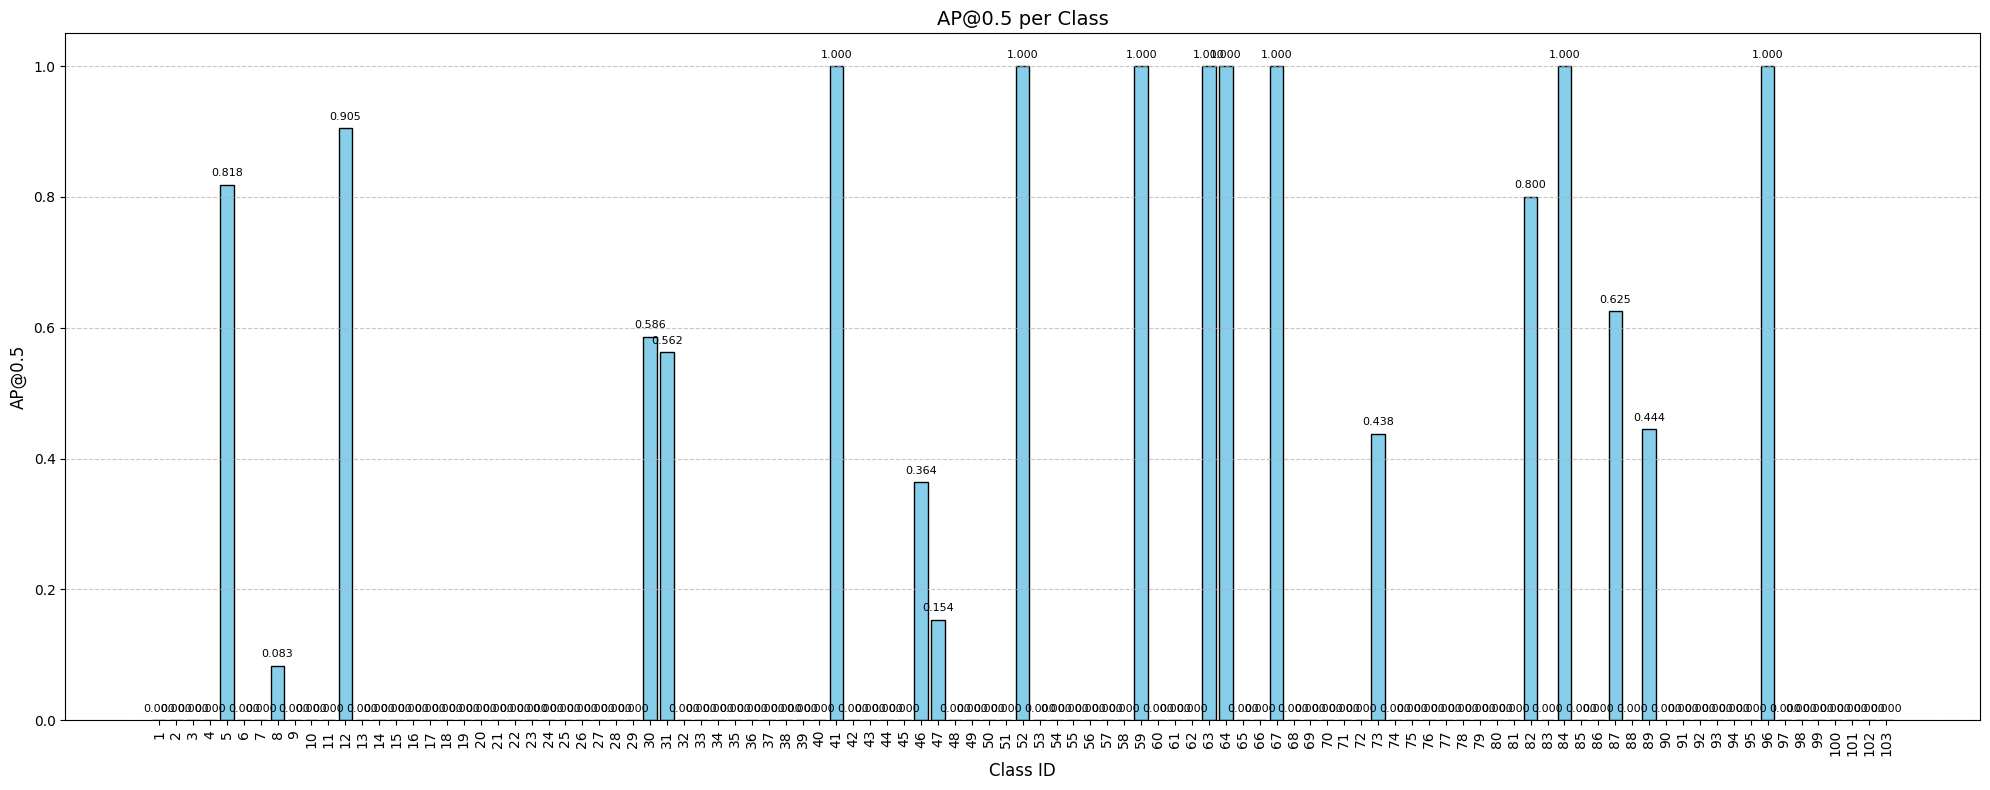

Displayed AP@0.5 plot in notebook


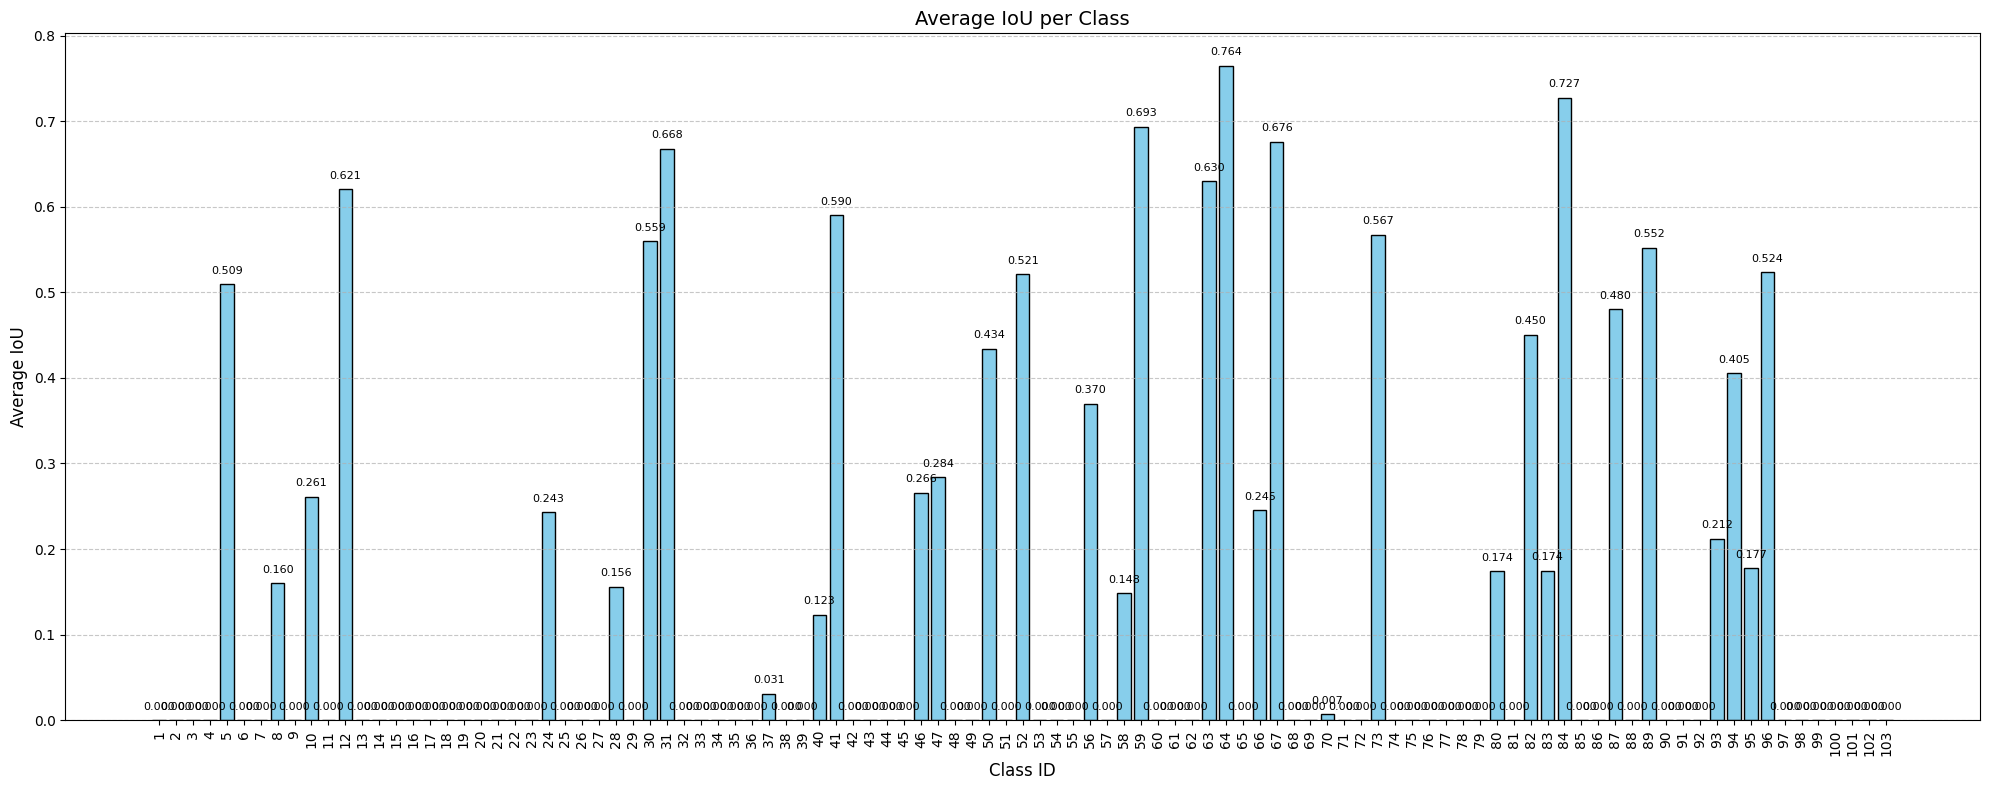

Displayed Avg_IoU plot in notebook


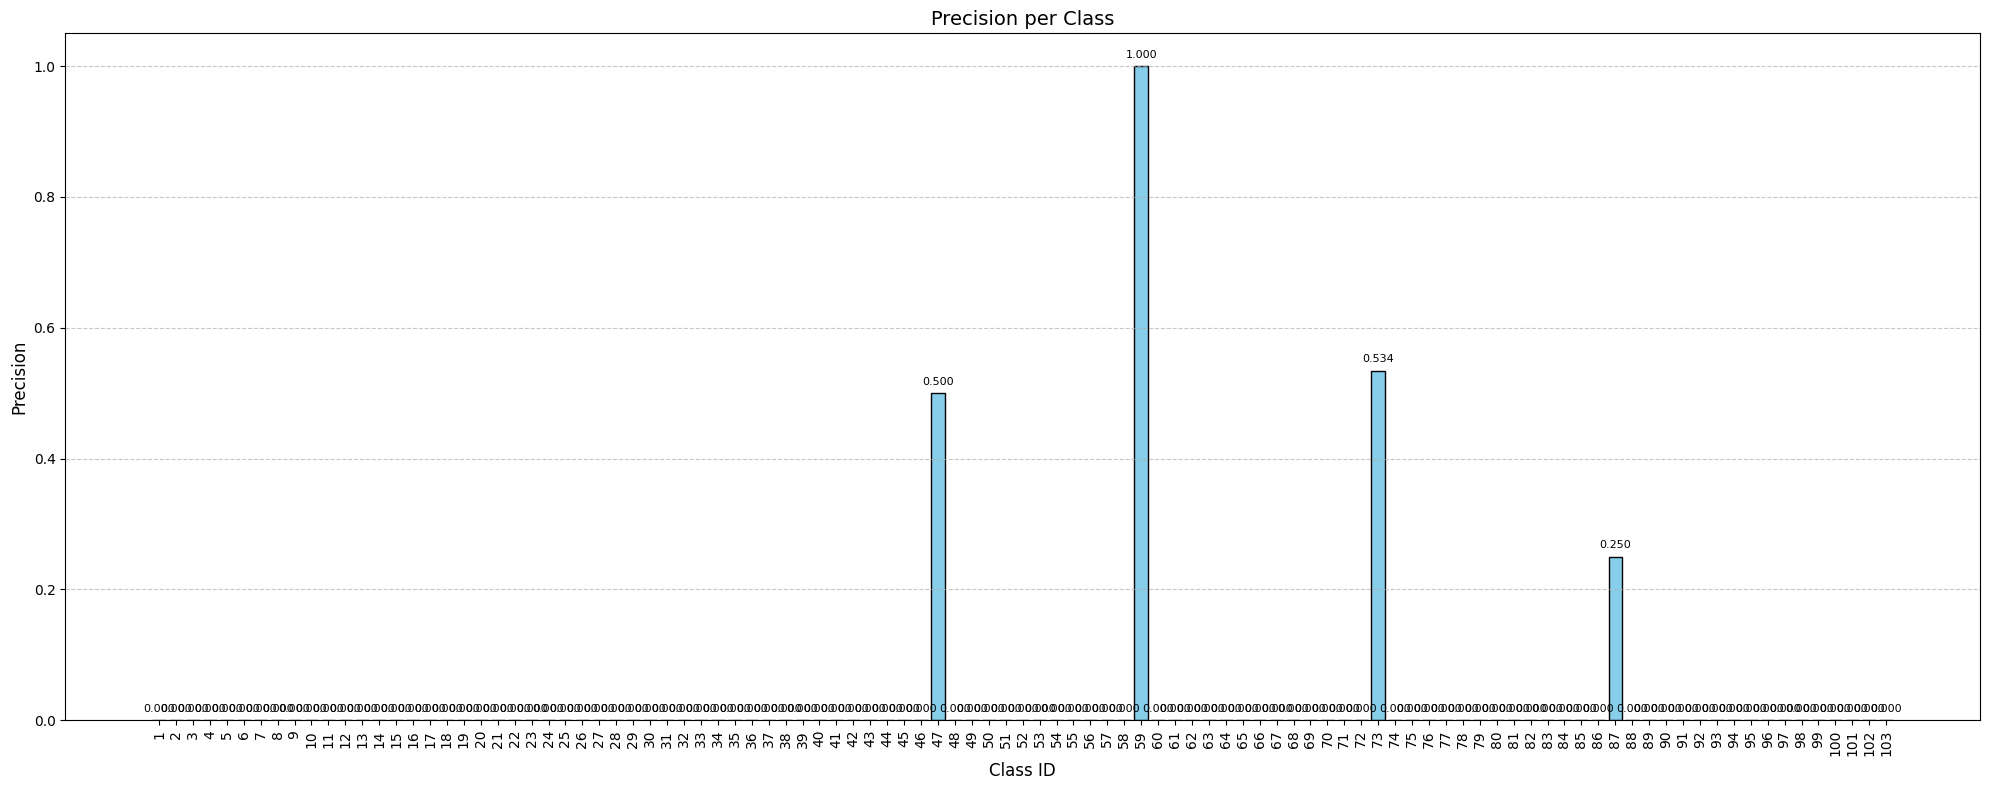

Displayed Precision plot in notebook


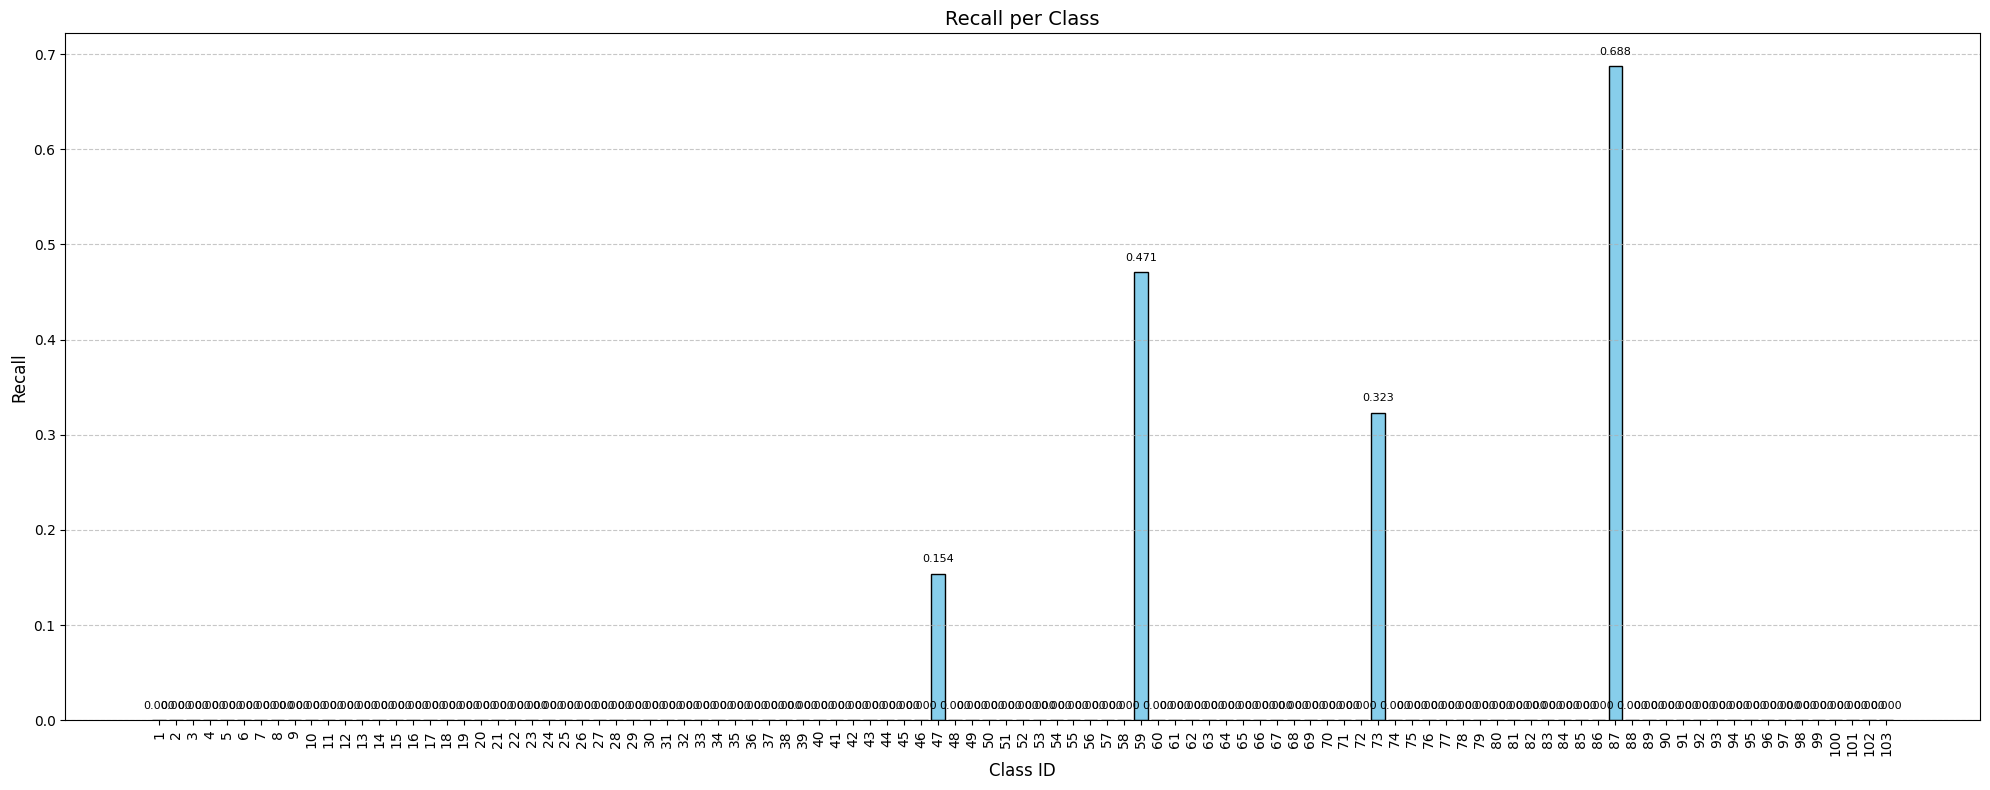

Displayed Recall plot in notebook


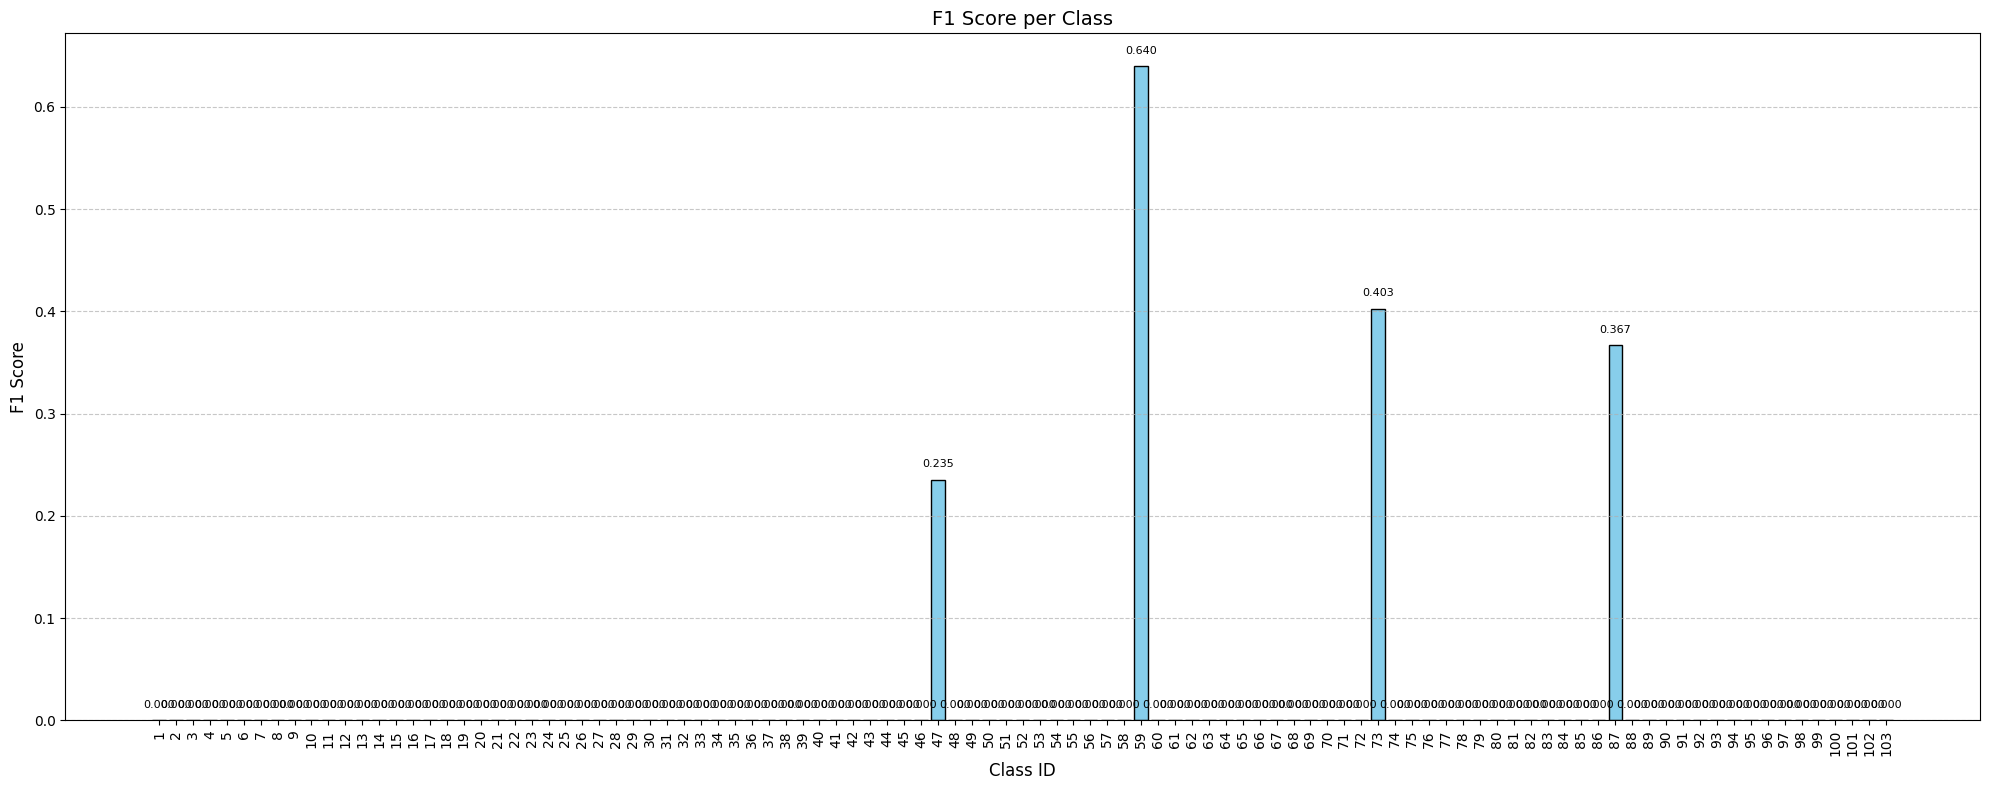

Displayed F1 plot in notebook


In [54]:
mean_ap, mean_iou = evaluate_sam(pred_dir, gt_dir, ingredients)

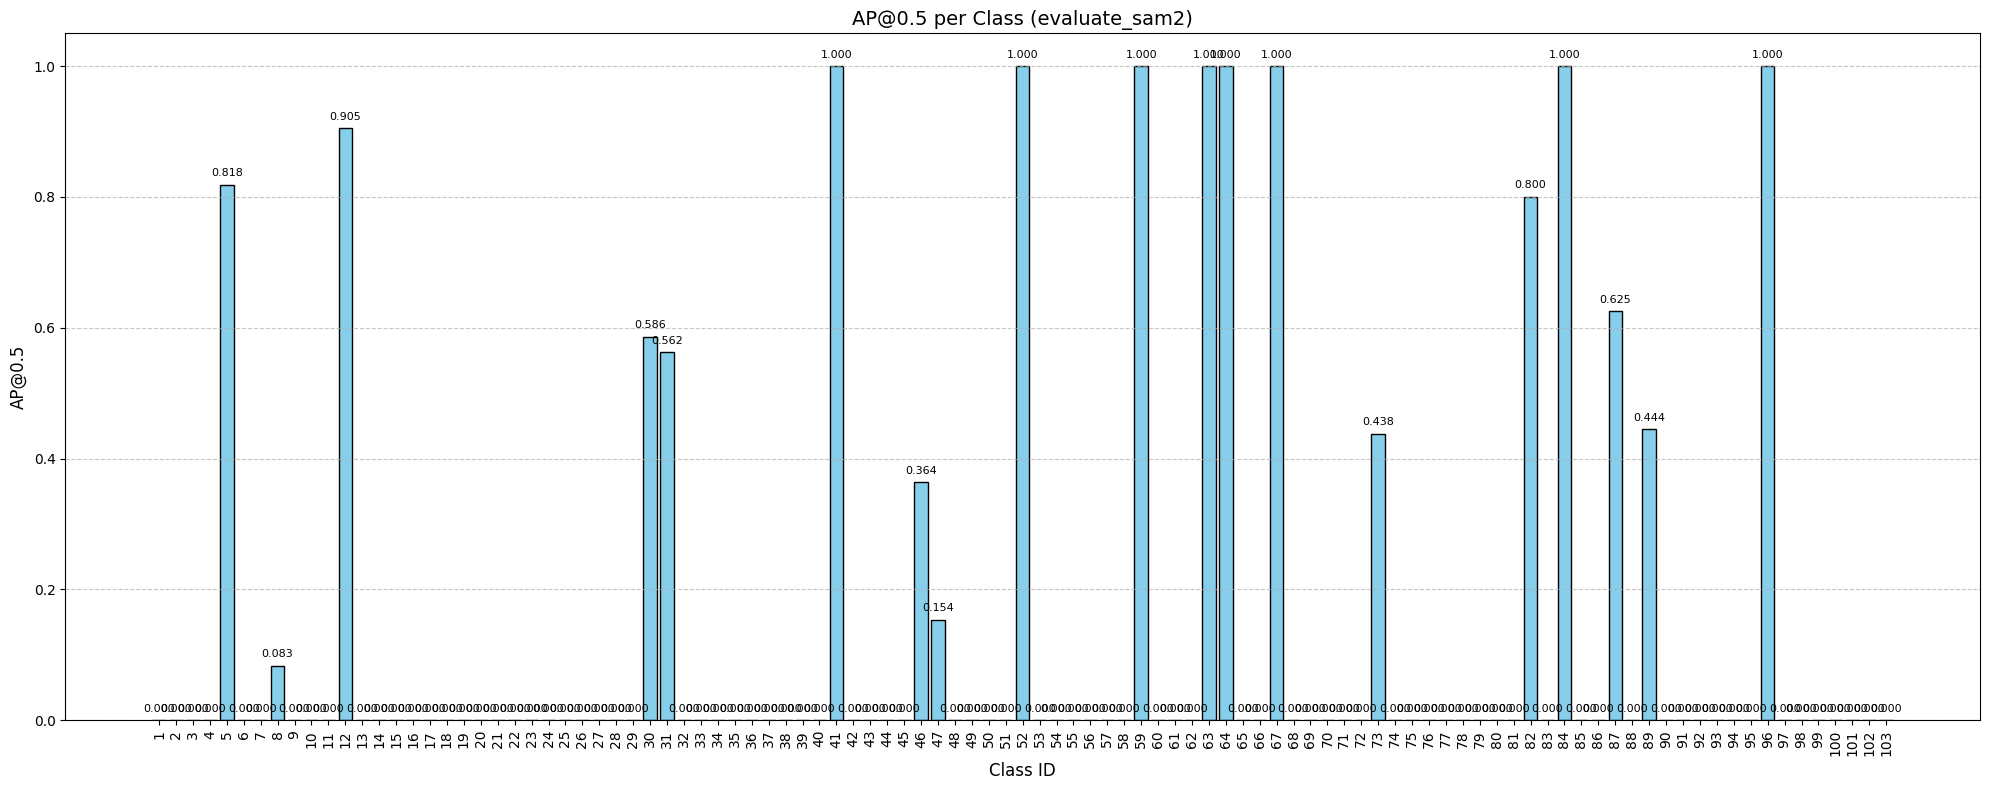

Displayed AP@0.5 plot in notebook


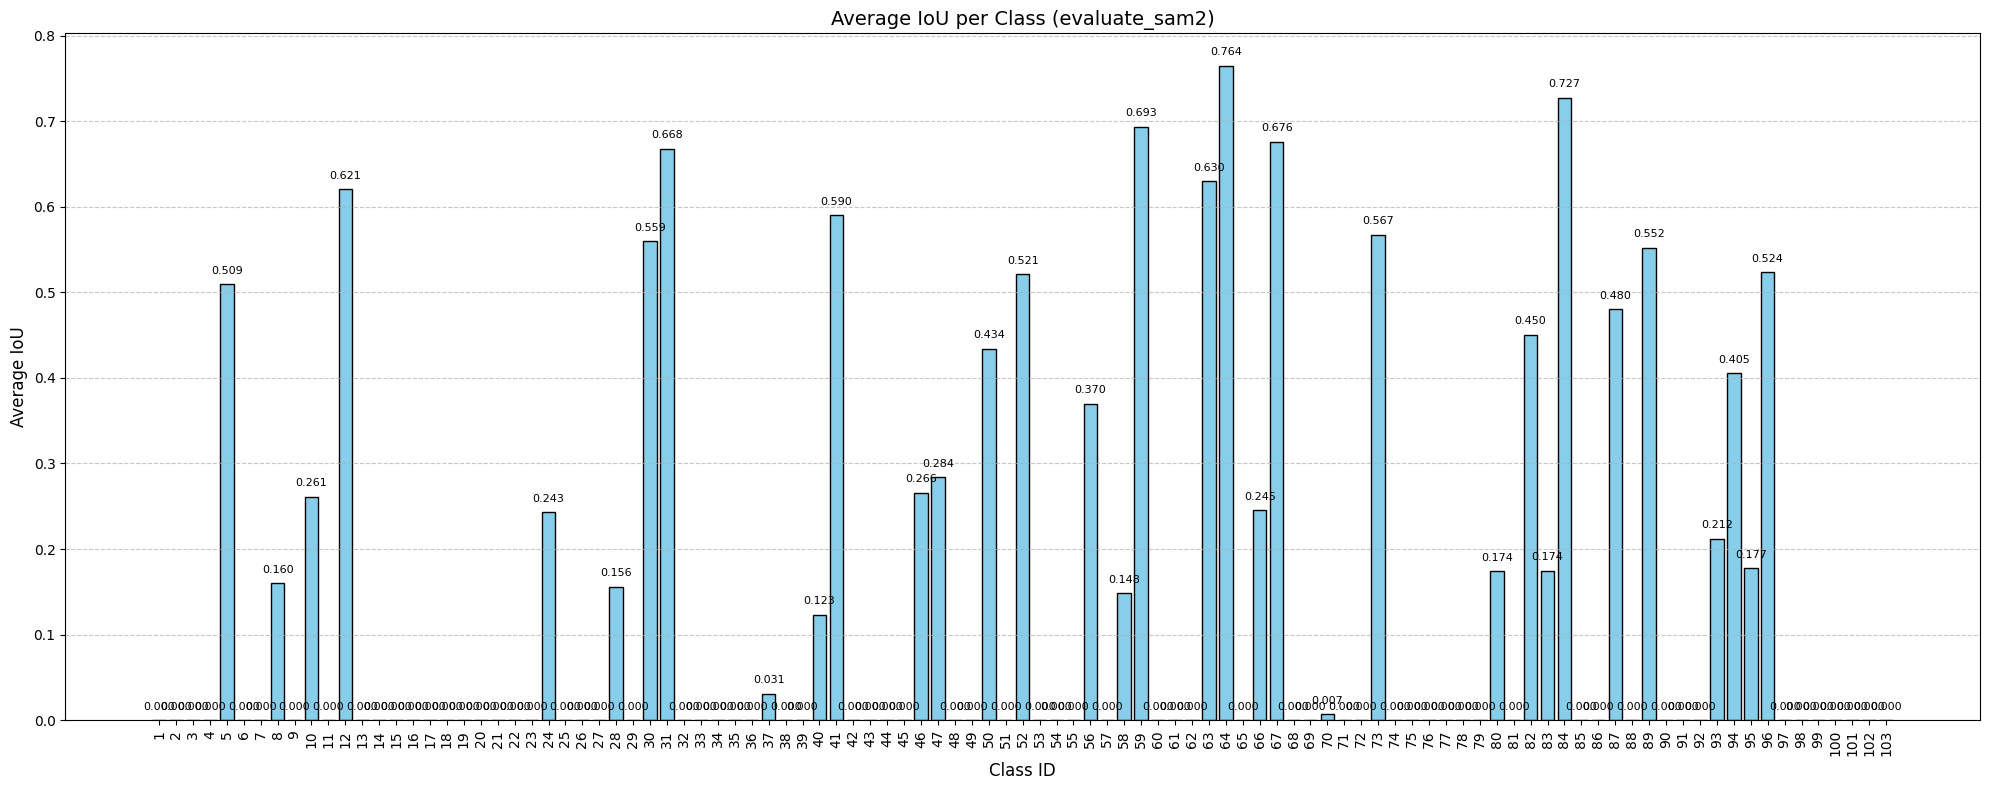

Displayed Avg_IoU plot in notebook


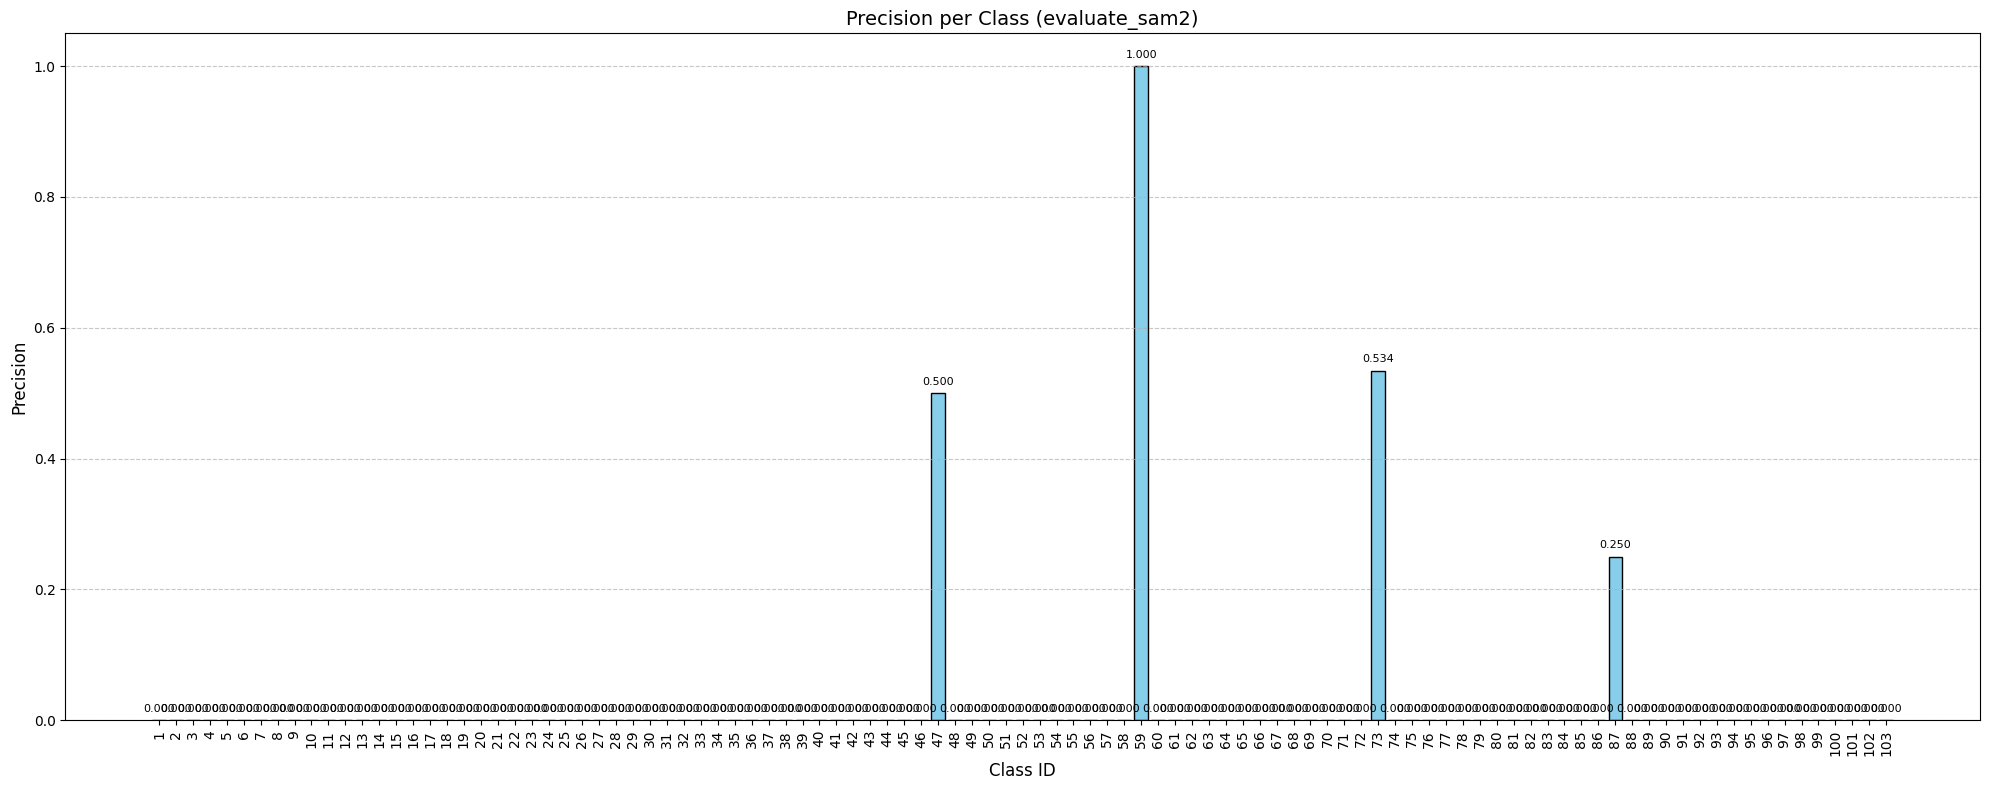

Displayed Precision plot in notebook


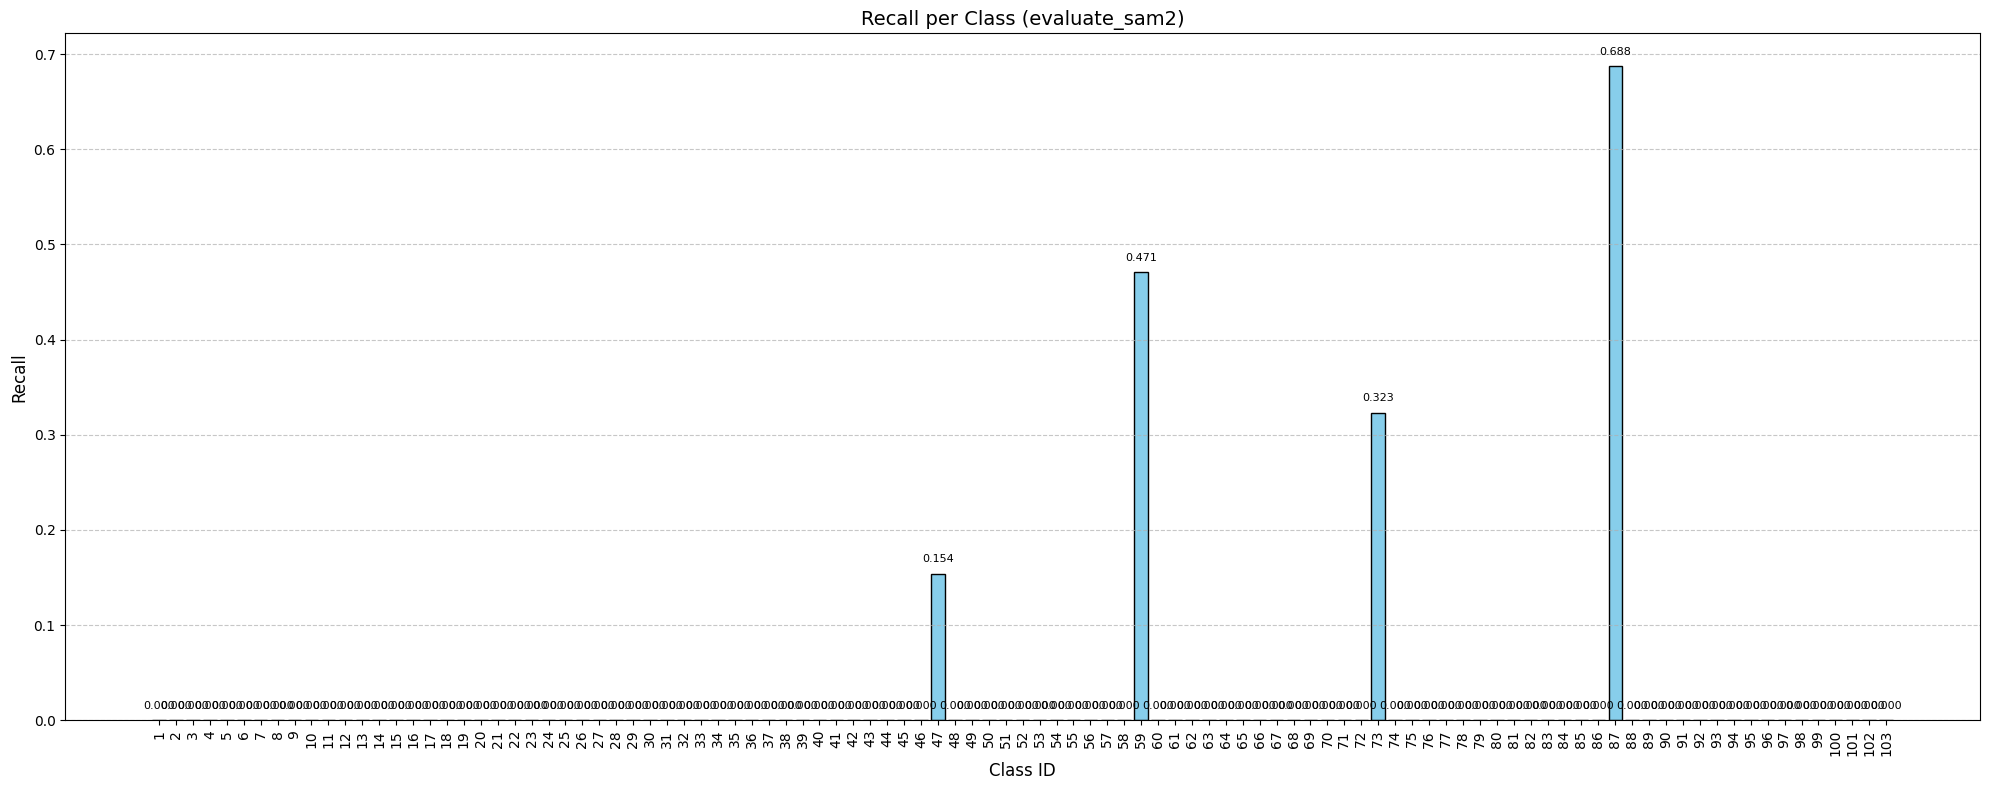

Displayed Recall plot in notebook


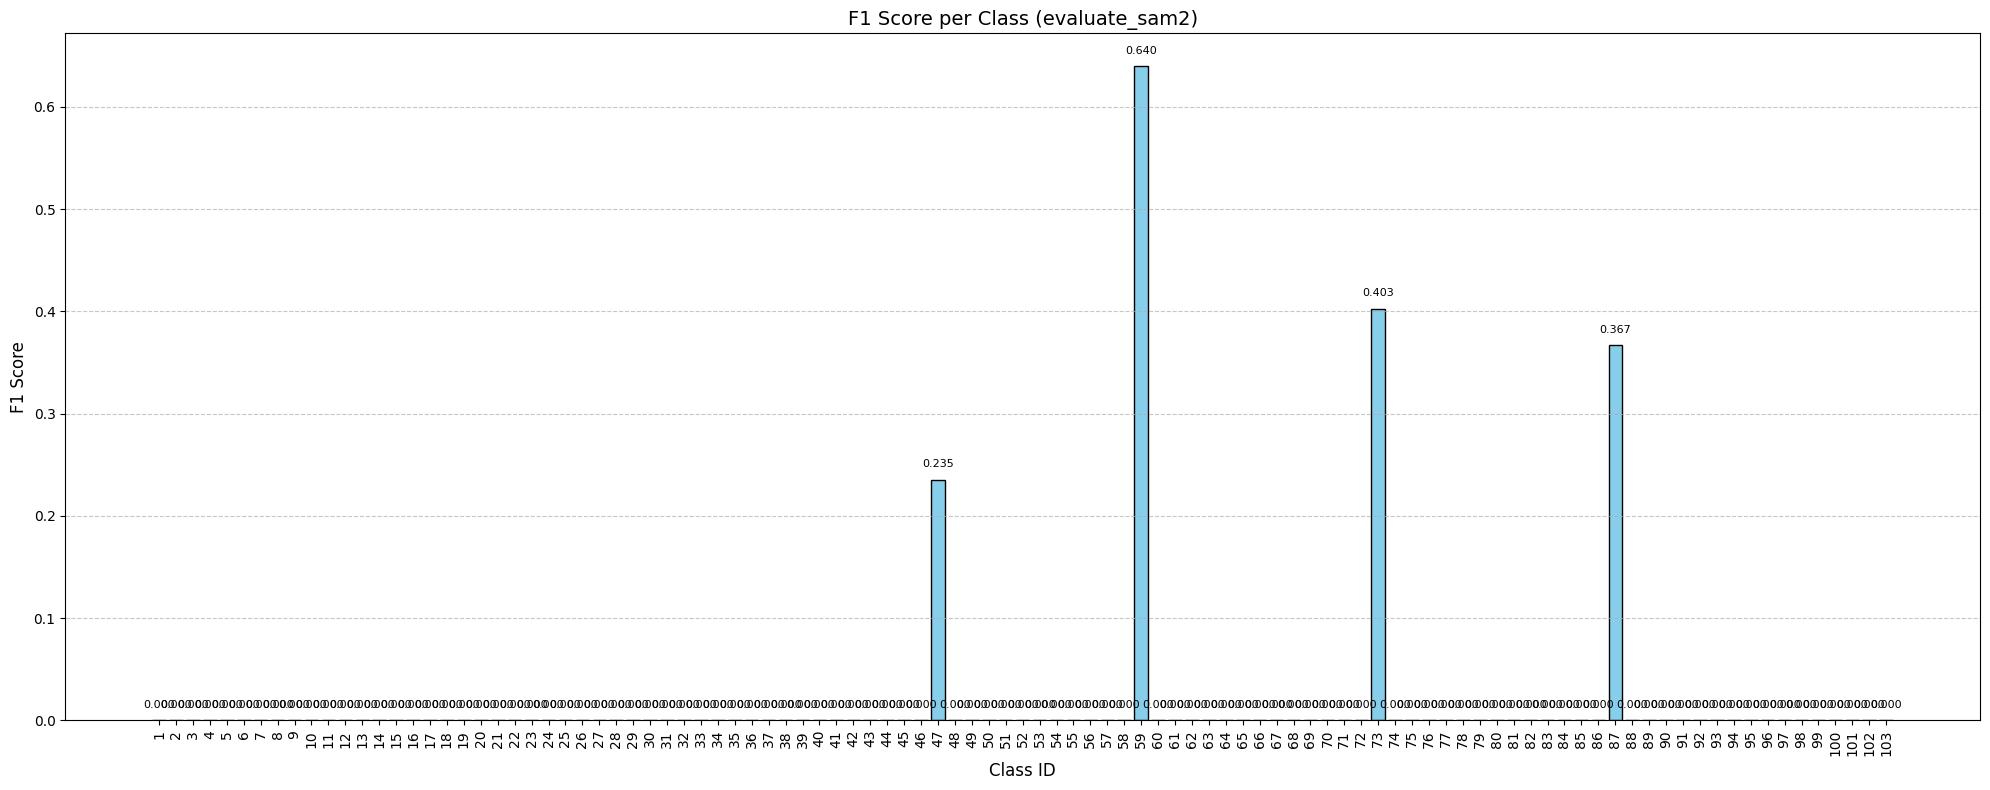

Displayed F1 plot in notebook


In [55]:
mean_ap2, mean_iou2 = evaluate_sam2(pred_dir, gt_dir, ingredients)

In [56]:
show_overall_performance(mean_ap, mean_iou)

mAP@0.5: 0.132
Mean IoU: 0.474
